In [206]:
# Importing all required packages .....

#!/usr/bin/env python
#import click
import numpy as np
import gym
import rlpa
import numpy as np
import warnings
from tqdm import tqdm
from random import randint, uniform
import sys
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
warnings.simplefilter('ignore')

In [375]:
### Function definitons to run policy gradient

def include_bias(state):
    
    return np.append(state,1)

def get_action(state):
    mean = theta.dot(include_bias(state))
    return np.random.multivariate_normal(mean = mean, cov = [[1, 0], [0, 1]])

def gradient(state, action):
    
    b_state = include_bias(state)
    mean = theta.dot(b_state)
    action -= mean
    b_state = b_state.reshape(b_state.shape[0], 1)
    action = action.reshape(action.shape[0], 1)
    grad = action.dot(np.transpose(b_state))
    return grad

def grad_w(ob):
    return np.transpose(include_bias(np.power(ob, 2)))
    
def policy_gradient(alpha_theta, alpha_omega, gamma, max_iter, batch_size, etype):

    if etype == 'chakra':
        env = gym.make('chakra-v0')

    else:
        env = gym.make('visham-v0')

    action_dim = env.action_space.shape[0]
    obs_dim = env.observation_space.shape[0]
    theta = np.zeros((action_dim, obs_dim + 1))
    omega = np.zeros(obs_dim + 1) 
    average_return = []
    
    for i in range(max_iter):
        
        delta_theta = np.zeros((action_dim, obs_dim + 1))
        delta_omega = np.zeros(obs_dim + 1)
        trajectories = []
        average_reward = 0
        start_state = env.reset()
        for j in range(batch_size):
            
            return_avg = 0
            retturn = 0
            g = 1
            trajectory = []
            curr_state = start_state
            done = False
            while not(done):
                
                action = get_action(curr_state)
                next_state, reward, done, _ = env.step(action)
                retturn += gamma * reward
                return_avg += retturn
                trajectory.append((curr_state, next_state, action, reward))
                curr_state = next_state
    
                
            return_avg /= float(len(trajectory))
            average_reward += len(trajectory)
        
            Return = 0
            grad_theta = np.zeros((action_dim, obs_dim + 1))
            grad_omega = np.zeros(obs_dim + 1)
            for backprop in reversed(trajectory):
            
                curr_state, _, curr_action, reward = backprop
                Return = reward + gamma * Return
                grad_theta += (Return - return_avg)*gradient(curr_state, curr_action)
            
            grad_theta = grad_theta / (np.linalg.norm(grad_theta) + 1e-8)
            delta_theta += alpha_theta * grad_theta
        average_reward /= float(batch_size)
        theta += delta_theta
        average_return.append(average_reward)
        
    return average_return, theta
    
def chakra_get_action(theta, ob, rng=np.random):
    ob_1 = include_bias(ob)
    mean = theta.dot(ob_1)
    return rng.normal(loc=mean, scale=1.)

#@click.command()
#@click.argument("env_id", type=str, default="chakra")
def main():
    env_id = 'chakra-v0'
    # Register the environment
    rng = np.random.RandomState(42)

    if env_id == 'chakra-v0' or env_id == 'visham-v0':
        env = gym.make(env_id)
        get_action = chakra_get_action
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
    else:
        raise ValueError(
            "Unsupported environment: must be 'chakra' or 'visham' ")

    env.seed(42)

    # Initialize parameters
    theta = rng.normal(scale=0.01, size=(action_dim, obs_dim + 1))

    while True:
        ob = env.reset()
        done = env.done
        # Only render the first trajectory
        # Collect a new trajectory
        rewards = []
        while not done:
            action = get_action(theta, ob, rng=rng)
            next_ob, rew, done, _ = env.step(action)
            ob = next_ob
            env.render()
            rewards.append(rew)

        print("Episode reward: %.2f" % np.sum(rewards))

In [378]:
# Averaging over different instances of the problem .....

def average():
    Return, theta = policy_gradient(0.5, 0.5, gamma = 0.9, max_iter = 200, batch_size = 30, etype='visham')
    for i in tqdm(range(2,51)):
        Return_, theta_ = policy_gradient(0.5, 0.5, gamma = 0.9, max_iter = 200, batch_size = 30, etype='visham')
        for j in range(len(Return)):
            Return[j] = Return[j] + (Return_[j] - Return[j])/i
        for k in range(len(theta)):
            theta[k] = theta[k] + (theta_[k] - theta_[k])/i
            
    return Return, theta

In [377]:
Return1, theta1 = average()



  0%|          | 0/49 [00:00<?, ?it/s]

  2%|▏         | 1/49 [00:03<02:33,  3.19s/it]

  4%|▍         | 2/49 [00:06<02:26,  3.13s/it]

  6%|▌         | 3/49 [00:09<02:22,  3.10s/it]

  8%|▊         | 4/49 [00:12<02:17,  3.05s/it]

 10%|█         | 5/49 [00:14<02:10,  2.98s/it]

 12%|█▏        | 6/49 [00:17<02:05,  2.92s/it]

 14%|█▍        | 7/49 [00:20<02:00,  2.87s/it]

 16%|█▋        | 8/49 [00:23<01:56,  2.83s/it]

 18%|█▊        | 9/49 [00:26<01:52,  2.81s/it]

 20%|██        | 10/49 [00:28<01:49,  2.80s/it]

 22%|██▏       | 11/49 [00:31<01:45,  2.78s/it]

 24%|██▍       | 12/49 [00:34<01:42,  2.77s/it]

 27%|██▋       | 13/49 [00:37<01:39,  2.77s/it]

 29%|██▊       | 14/49 [00:39<01:36,  2.75s/it]

 31%|███       | 15/49 [00:42<01:33,  2.74s/it]

 33%|███▎      | 16/49 [00:45<01:30,  2.73s/it]

 35%|███▍      | 17/49 [00:47<01:27,  2.74s/it]

 37%|███▋      | 18/49 [00:50<01:24,  2.74s/it]

 39%|███▉      | 19/49 [00:53<01:22,  2.75s/it]

 41%|████      | 20/49 [00:56<01:19,

In [403]:
### PLOTTING VALUE FUNCTION ....

def plot_valuefn(omega):
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    X, Y = np.meshgrid(x, y)
    ob = np.array([X,Y])
    Z = (w[0][0]*np.power(X, 2) + w[0][1]*np.power(Y, 2) + w[0][2])
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_title('chakra value function')
    plt.show()

In [379]:
Return2, theta2 = average()



  0%|          | 0/49 [00:00<?, ?it/s]

  2%|▏         | 1/49 [00:03<02:27,  3.08s/it]

  4%|▍         | 2/49 [00:06<02:26,  3.11s/it]

  6%|▌         | 3/49 [00:09<02:24,  3.15s/it]

  8%|▊         | 4/49 [00:13<02:27,  3.28s/it]

 10%|█         | 5/49 [00:16<02:32,  3.46s/it]

 12%|█▏        | 6/49 [00:20<02:26,  3.41s/it]

 14%|█▍        | 7/49 [00:23<02:24,  3.44s/it]

 16%|█▋        | 8/49 [00:27<02:22,  3.49s/it]

 18%|█▊        | 9/49 [00:30<02:19,  3.49s/it]

 20%|██        | 10/49 [00:33<02:08,  3.29s/it]

 22%|██▏       | 11/49 [00:36<01:57,  3.10s/it]

 24%|██▍       | 12/49 [00:38<01:49,  2.96s/it]

 27%|██▋       | 13/49 [00:41<01:43,  2.87s/it]

 29%|██▊       | 14/49 [00:44<01:38,  2.80s/it]

 31%|███       | 15/49 [00:46<01:34,  2.77s/it]

 33%|███▎      | 16/49 [00:49<01:30,  2.74s/it]

 35%|███▍      | 17/49 [00:52<01:27,  2.72s/it]

 37%|███▋      | 18/49 [00:54<01:23,  2.70s/it]

 39%|███▉      | 19/49 [00:57<01:20,  2.69s/it]

 41%|████      | 20/49 [01:00<01:17,

In [401]:
w =theta2

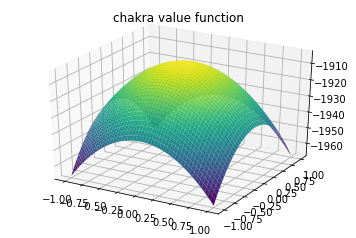

In [406]:
plot_valuefn(w)

In [404]:
### DISPLAYING TRAJECTORY ....

def plot_trajectory(theta):
    x = np.linspace(1, -1, 20)
    y = np.linspace(1, -1, 20)
    X, Y = np.meshgrid(x, y)
    action = [];
    for i in x:
        for j in y:
            action.append(np.mean(chakra_get_action(theta, np.array([i,j]),rng=np.random)))
    
    fig = plt.figure()
    fig.suptitle('Trajectory to reach goal in chakra', fontsize = 16)
    plt.xlabel('x', fontsize = 14)
    plt.ylabel('y', fontsize = 14)
    plt.quiver(X,Y,action)
    plt.show()    

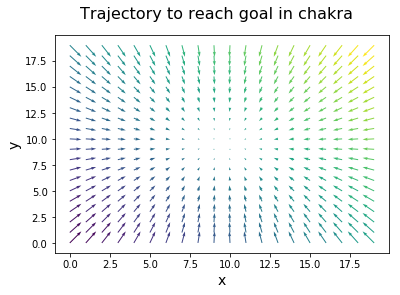

In [405]:
plot_trajectory(theta1)